In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

from sklearn.metrics import adjusted_rand_score

In [73]:
################################################## HELPER FUNCTIONS #################################################################################### 
def z_scoring(x): 
    return (x - x.mean()) / x.std()

def range_normalization(x):
    return (x - x.mean()) / (x.max() - x.min())

def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

# Used to group dataPoints in clusters
def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

# To See if it belongs to Cluster X?
def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

# Optimized Vectorized implementation
# Validation / Criterion
def xie_beni_index(U, centers, X):
    um = U ** 2
    dist_sq = np.sum((X[np.newaxis, :, :] - centers[:, np.newaxis, :]) ** 2, axis=2)
    compactness = np.sum(um * dist_sq)

    center_dist_sq = np.sum((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2, axis=2)
    np.fill_diagonal(center_dist_sq, np.inf)
    min_center_dist_sq = np.min(center_dist_sq)

    if min_center_dist_sq == 0:
        return np.inf
    return compactness / (X.shape[0] * min_center_dist_sq)

def plot_clustering(x, labels, centers, title, score):
    plt.figure(figsize=(8, 6))
    for j in np.unique(labels):
        plt.scatter(x[labels == j, 0], x[labels == j, 1], label=f'Cluster {j+1}')
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')
    plt.title(f"{title} (Score={score:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [74]:
################################################## DATA PREPARATION #################################################################################### 

# a ) Normalize by range and z-score
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

features = data.drop(columns=['quality'])  # Remove 'quality' column for features
true_labels = data['quality'].values

data_excluding_last_column = data.iloc[:, :-1]

# Then convert the result to a NumPy array and change the dtype
x = data_excluding_last_column.values.astype(np.float32)

normalization = 0
threshold = 25

#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data

In [75]:

# x, me range, d
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # counter of anomalous clusters 
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :]   # initial anomalous center reference point: the one with higher distance
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid with parameters of the data   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d)) # cluster contribution (per cent) - (lecture on K-means and iK-means)

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append((cluster, censtand, dD))

ancl = np.array(ancl, dtype=object)

##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)

#print("\nInitial centroids selected for each cluster:")
#for idx, centroid in enumerate(cent):
 #   print(f"Cluster {idx + 1} centroid: {centroid}")

#init_partition = np.zeros((x.shape[0], len(cent)))

#for index, d in enumerate(x):
 #   dists = [np.linalg.norm(d - c) for c in cent]
  #  dists = np.fmax(dists, 1e-6)
   # inv_dists = 1.0 / dists
    #memberships = inv_dists / np.sum(inv_dists)
    #init_partition[index] = memberships

    #assign = dists.index(np.min(dists))
    #init_partition[index, assign] = 1

#print("Initial cluster assignments (partition matrix): \n", init_partition)

c=2 | Cost=6833630.4863 | Xie-Beni=0.1067 | Silhouette=0.5094 | ARI=0.0025
c=3 | Cost=3121175.0195 | Xie-Beni=0.1012 | Silhouette=0.5050 | ARI=0.0042
c=4 | Cost=1987109.8701 | Xie-Beni=0.1411 | Silhouette=0.4500 | ARI=0.0036
c=5 | Cost=1446732.8194 | Xie-Beni=0.1569 | Silhouette=0.4163 | ARI=0.0021
c=6 | Cost=1144620.8339 | Xie-Beni=0.1845 | Silhouette=0.3800 | ARI=0.0035
c=7 | Cost=936837.5565 | Xie-Beni=0.2022 | Silhouette=0.3594 | ARI=0.0023


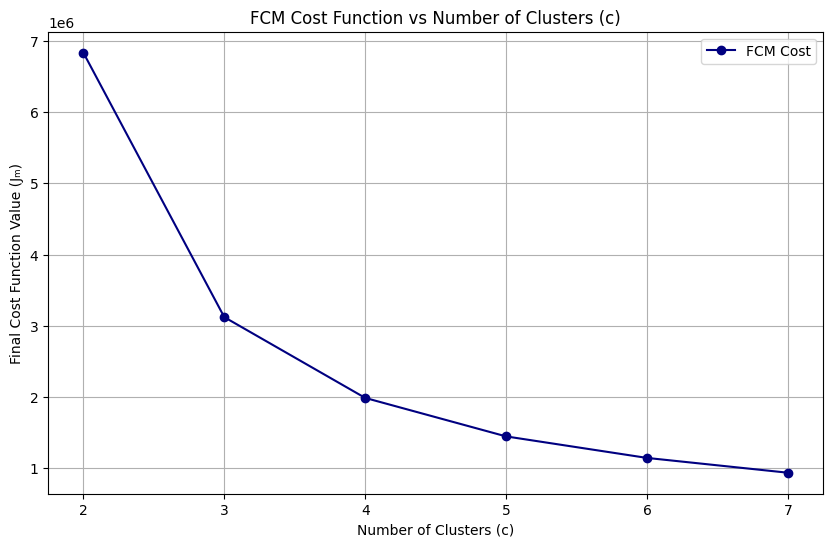

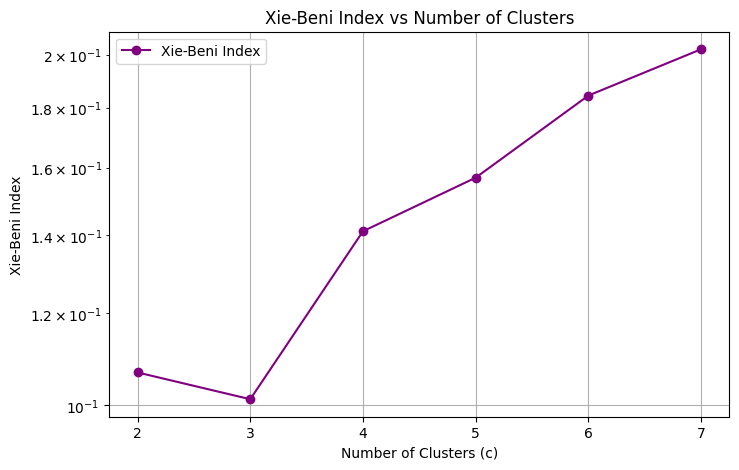

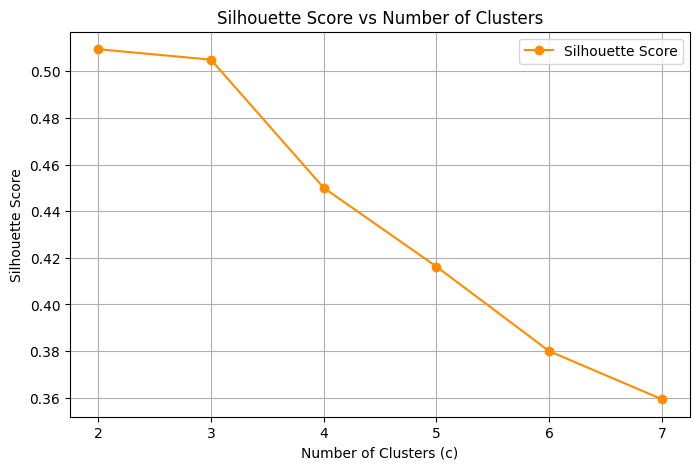

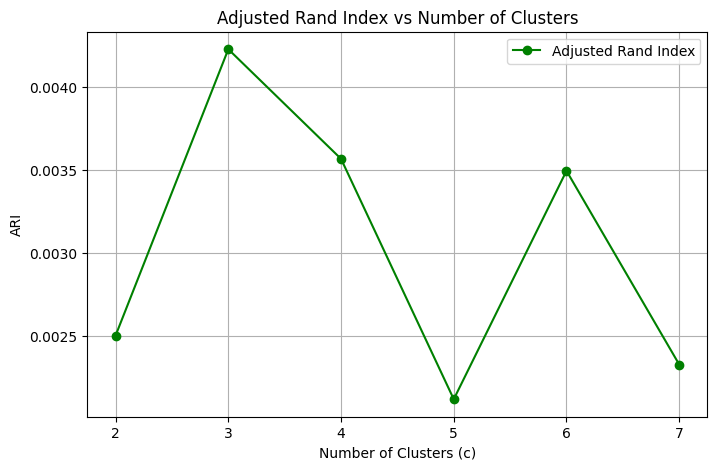

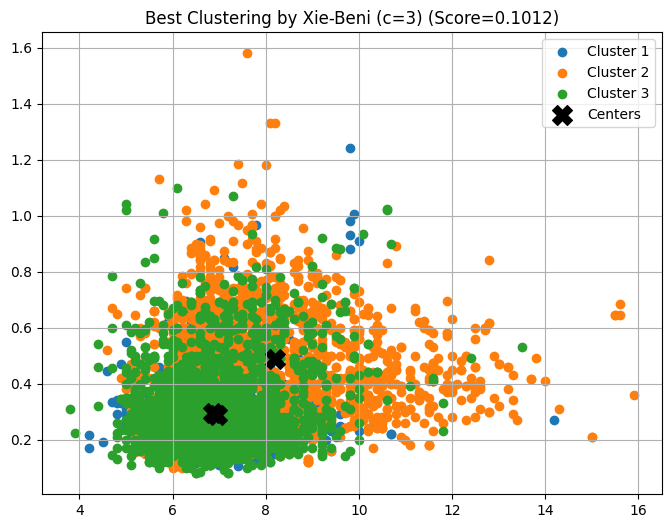

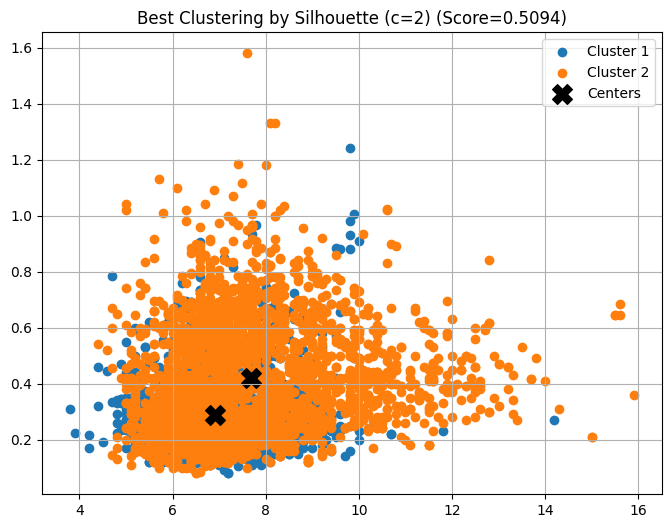

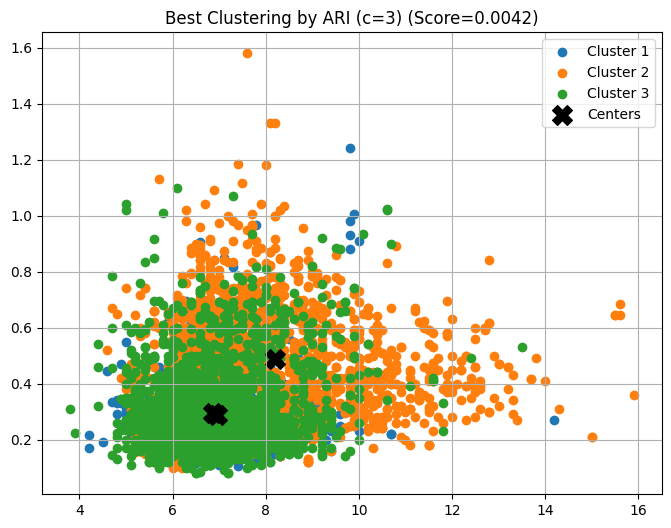

In [76]:
# b) 
costs = []
c_values = list(range(2, 8))

# Validations
xie_beni_scores = []
silhouette_scores = []
ari_scores = []

# For standard deviation in cost plots
costs_std = []

# Best Results for each c
best_results_xie = {}         
best_results_silhouette = {}  
best_results_ari = {}

for c in c_values:
    run_costs = []
    run_xie_beni = []
    run_silhouettes = []
    run_aris = []

    best_xie_beni_score = np.inf
    best_silhouette_score = -1.0
    best_ari_score = -1.0

    best_result_xie = None
    best_result_silhouette = None
    best_result_ari = None
    
    current_centroids = cent[:c]

    # Build init partition for this c
    init_partition = np.zeros((x.shape[0], c))
    for index, d in enumerate(x):
        dists = [np.linalg.norm(d - c_) for c_ in current_centroids]
        dists = np.fmax(dists, 1e-6)
        inv_dists = 1.0 / dists
        memberships = inv_dists / np.sum(inv_dists)
        init_partition[index] = memberships
        
    
    centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(
        x.T, c, 2.0, 1e-5, 100, init=init_partition.T)
    
    # FCM Cost Function
    cost = jm[-1]
    labels = np.argmax(fm, axis=0)

    # Validation Indices
    xie_score = xie_beni_index(fm, centers, x)
    sil_score = silhouette_score(x, labels)
    ari = adjusted_rand_score(true_labels, labels)

    # Store scores
    costs.append(cost)
    xie_beni_scores.append(xie_score)
    silhouette_scores.append(sil_score)
    ari_scores.append(ari)

    best_results_xie[c] = (centers, fm, xie_score, labels)
    best_results_silhouette[c] = (centers, fm, sil_score, labels)
    best_results_ari[c] = (centers, fm, ari, labels)

    print(f"c={c} | Cost={cost:.4f} | Xie-Beni={xie_score:.4f} | Silhouette={sil_score:.4f} | ARI={ari:.4f}")
    

# Cost Function vs c
plt.figure(figsize=(10, 6))
plt.plot(c_values, costs, marker='o', color='navy', label="FCM Cost")
plt.title("FCM Cost Function vs Number of Clusters (c)")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Final Cost Function Value (Jₘ)")
plt.grid(True)
plt.legend()
plt.show()

# Xie-Beni Index vs c
plt.figure(figsize=(8, 5))
plt.plot(c_values, xie_beni_scores, marker='o', color='purple', label="Xie-Beni Index")
plt.title("Xie-Beni Index vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Xie-Beni Index")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

# Silhouette Score vs c
plt.figure(figsize=(8, 5))
plt.plot(c_values, silhouette_scores, marker='o', color='darkorange', label="Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()
plt.show()

# ARI Score vs c
plt.figure(figsize=(8, 5))
plt.plot(c_values, ari_scores, marker='o', color='green', label="Adjusted Rand Index")
plt.title("Adjusted Rand Index vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("ARI")
plt.grid(True)
plt.legend()
plt.show()


# Best by Xie-Beni
best_c_xie = c_values[np.argmin(xie_beni_scores)]
centers, fm, score, labels = best_results_xie[best_c_xie]
plot_clustering(x, labels, centers, f"Best Clustering by Xie-Beni (c={best_c_xie})", score)

# Best by Silhouette
best_c_sil = c_values[np.argmax(silhouette_scores)]
centers, fm, score, labels = best_results_silhouette[best_c_sil]
plot_clustering(x, labels, centers, f"Best Clustering by Silhouette (c={best_c_sil})", score)

# Best by ARI
best_c_ari = c_values[np.argmax(ari_scores)]
centers, fm, score, labels = best_results_ari[best_c_ari]
plot_clustering(x, labels, centers, f"Best Clustering by ARI (c={best_c_ari})", score)